In [1]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torch.nn.functional import gumbel_softmax


In [2]:
# device = torch.device('mps')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, init_temperature, anneal_rate):
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)  # 输出logits
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim
        self.temperature = init_temperature
        self.anneal_rate = anneal_rate
    
    def reparameterize(self, logits):
        y = F.gumbel_softmax(logits, tau=self.temperature, dim=-1)
        return y

    def forward(self, x):
        logits = self.encoder(x)
        z = self.reparameterize(logits)
        return self.decoder(z), logits

    def anneal(self):
        self.temperature *= self.anneal_rate

def compute_loss(recon_x, x, logits, latent_dim):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    q_y = F.softmax(logits, dim=-1)
    log_q_y = torch.log(q_y + 1e-20)
    KLD = torch.sum(q_y * (log_q_y - torch.log(torch.tensor(1.0 / latent_dim))), dim=-1).mean()
    return BCE + KLD, BCE, KLD

train_losses = []

def train(model, dataloader, optimizer, epoch, pbar):
    model.train()
    train_loss = 0
    BCE_loss = 0
    KLD_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):  # 不需要标签
        data = data.view(-1, 784)  # Flatten the images
        data = data.to(device)
        
        recon_batch, logits = model(data)
        # loss, BCE, KLD = compute_loss(recon_batch, data, logits, model.latent_dim)
        try:
            BCE_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum') / data.shape[0]
        except RuntimeError as e:
            # print(e)
            break
        q_y = F.softmax(logits, dim=-1)
        log_q_y = torch.log(q_y + 1e-20)
        KLD_loss = torch.sum(q_y * (log_q_y - torch.log(torch.tensor(1.0 / model.latent_dim))), dim=-1).mean()
        loss = BCE_loss + KLD_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        BCE_loss = BCE_loss.item()
        KLD_loss = KLD_loss.item()
        train_loss = loss.item()
        train_losses.append((train_loss, BCE_loss, KLD_loss))

        pbar.set_description(f'Train Epoch: {epoch} | BCE: {BCE_loss:.2f} KLD: {KLD_loss:.7f} | Temp: {model.temperature:.7f} Lr: {optimizer.param_groups[0]["lr"]:.7f}')
        pbar.update()
    return train_loss, BCE_loss, KLD_loss

def get_data_loader(dataset_name, transform, batch_size):
    if dataset_name == 'MNIST':
        dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    elif dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    # ...
    else:
        raise ValueError('Invalid dataset name')

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def generate_digit(model, z):
    # model: trained model
    # z: latent variable, torch.Tensor of shape (latent_dim,)

    # Pass through the decoder
    digit = model.decoder(z)

    # Reshape and visualize the digit
    digit_reshaped = digit.view(28, 28).detach().cpu()
    plt.imshow(digit_reshaped, cmap='gray')
    # plt.show()
    return digit_reshaped

def predict_label(model, data, label):
    # model: trained model
    # data: image data, torch.Tensor of shape (1, 784)
    # label: class label, integer

    # Perform one-hot encoding on the label
    label_onehot = torch.zeros(10).to(data.device)  # Assuming there are 10 classes
    label_onehot[label] = 1.

    # Pass through the encoder
    combined_input = torch.cat([data, label_onehot], dim=1)
    logits = model.encoder(combined_input)
    y = F.softmax(logits, dim=-1)
    return y

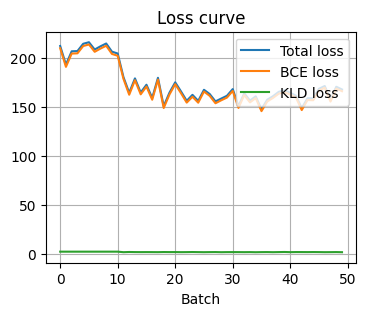

Train Epoch: 50 | BCE: 165.75 KLD: 1.7466120 | Temp: 0.6111172 Lr: 0.0010000:  99%|█████████▉| 59533/60000 [08:20<00:03, 119.05it/s]


In [4]:
from IPython.display import clear_output

# Run the main function on MNIST
input_dim = 784  # 28*28, size of MNIST images
hidden_dim = 30
latent_dim = 10
init_temperature = 1.0
anneal_rate = 0.99
epochs = 50
batch_size = 50

# Initialize the model and optimizer
model = CVAE(input_dim, hidden_dim, latent_dim, init_temperature, anneal_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs, gamma=0.9)

# Prepare to plot the loss
losses = []
fig = plt.figure()

def live_plot(data_dict, figsize=(4,3), title='Loss curve'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Batch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show()

def main(dataset_name):
    # Prepare the data
    transform = transforms.ToTensor()
    dataloader = get_data_loader(dataset_name, transform, batch_size)
    
    print(f'epoch: {epochs}, size of dataloader: {len(dataloader)}')
    pbar = tqdm(total=epochs*len(dataloader))
    for epoch in range(1, epochs + 1):
        total_loss, BCE_loss, KLD_loss = train(model, dataloader, optimizer, epoch, pbar)
        lr_scheduler.step()
        model.anneal()
        losses.append((total_loss, BCE_loss, KLD_loss))
        data_dict = {'Total loss': [x[0] for x in losses], 'BCE loss': [x[1] for x in losses], 'KLD loss': [x[2] for x in losses]}
        live_plot(data_dict)
    pbar.close()

main('MNIST')


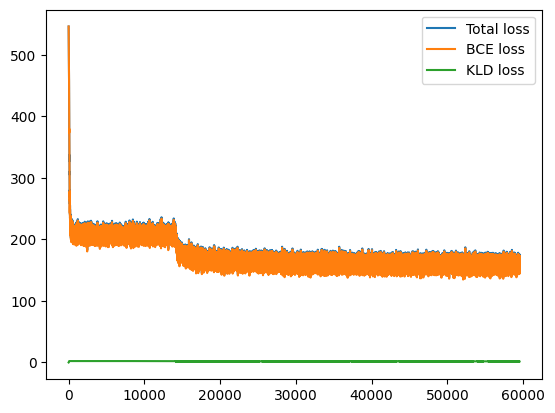

Average total loss: 174.591
Average BCE loss: 172.639
Average KLD loss: 1.952
Final total loss: 167.498
Final BCE loss: 165.752
Final KLD loss: 1.747


In [5]:
#  Plot the loss curve
plt.figure()
plt.plot([x[0] for x in train_losses], label='Total loss')
plt.plot([x[1] for x in train_losses], label='BCE loss')
plt.plot([x[2] for x in train_losses], label='KLD loss')
plt.legend()
plt.show()

# Calculate the avg losses
avg_total_loss = [x[0] for x in train_losses]
avg_BCE_loss = [x[1] for x in train_losses]
avg_KLD_loss = [x[2] for x in train_losses]
print('Average total loss: {:.3f}'.format(sum(avg_total_loss) / len(avg_total_loss)))
print('Average BCE loss: {:.3f}'.format(sum(avg_BCE_loss) / len(avg_BCE_loss)))
print('Average KLD loss: {:.3f}'.format(sum(avg_KLD_loss) / len(avg_KLD_loss)))

# Print the final loss
print('Final total loss: {:.3f}'.format(train_losses[-1][0]))
print('Final BCE loss: {:.3f}'.format(train_losses[-1][1]))
print('Final KLD loss: {:.3f}'.format(train_losses[-1][2]))


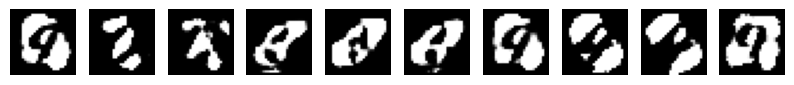

In [6]:
# Plot the generated digits
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    z = torch.randn(1, latent_dim).to(device)
    digit = generate_digit(model, z)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
plt.show()

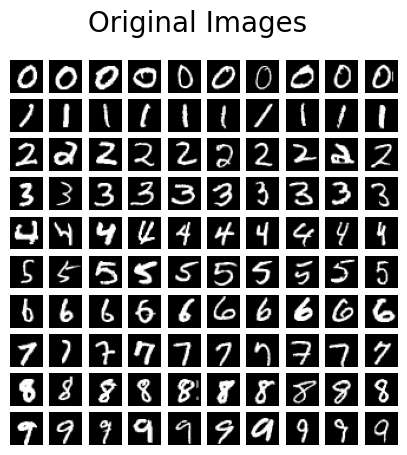

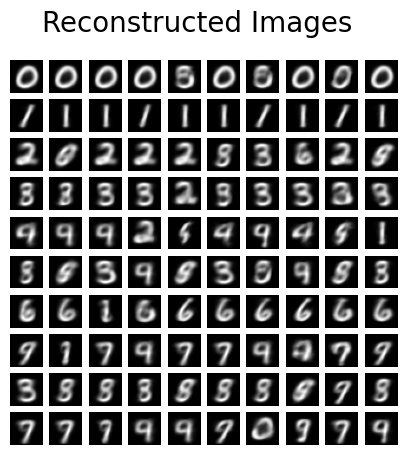

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get the data loader
# transform = transforms.ToTensor()
# dataloader = get_data_loader('MNIST', transform, batch_size=128)

# # Prepare a 10x10 grid
# fig, axs = plt.subplots(10, 10, figsize=(20, 20))

# # For each class (0-9)
# for i in range(10):
#     # Get 10 samples from the class
#     samples = []
#     for data, labels in dataloader:
#         indices = (labels == i).nonzero(as_tuple=True)[0]
#         for idx in indices[:10]:
#             samples.append(data[idx])
#         if len(samples) >= 10:
#             break
    
#     # For each sample
#     for j in range(10):
#         sample = samples[j].view(-1, 784).to(device)
#         # Pass the sample through the model
#         recon_batch, _ = model(sample)
#         # Reshape the output and plot it
#         recon_img = recon_batch.view(28, 28).detach().cpu().numpy()
#         axs[i, j].imshow(recon_img, cmap='gray')
#         axs[i, j].axis('off')

# plt.show()
import matplotlib.pyplot as plt

# 1. Randomly pick 10 images from each class (0 - 9) as the test data
test_data = []
dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for i in range(10):
    class_data = []
    for data, labels in dataloader:
        class_indices = (labels == i).nonzero(as_tuple=True)[0]
        class_data.extend(data[class_indices])
        if len(class_data) >= 10:
            break
    test_data.extend(class_data[:10])

# 2. Show the selected images
fig, axs = plt.subplots(10, 10, figsize=(5, 5))  # Creates a grid of 10*10 subplots

for i in range(10):
    for j in range(10):
        img = test_data[i*10 + j]
        axs[i, j].imshow(img.squeeze().cpu().numpy(), cmap='gray')
        axs[i, j].axis('off')
plt.suptitle('Original Images', fontsize=20)
plt.show()


# 3. Pass the images through the model and show the reconstructed images
fig, axs = plt.subplots(10, 10, figsize=(5, 5))  # Creates a grid of 10*10 subplots

for i in range(10):
    for j in range(10):
        img = test_data[i*10 + j]
        img = img.to(device)
        img = img.view(-1, 784)  # Flatten the images
        recon_img, _ = model.forward(img)
        recon_img = recon_img.view(28, 28).detach().cpu().numpy()
        axs[i, j].imshow(recon_img, cmap='gray')
        axs[i, j].axis('off')
plt.suptitle('Reconstructed Images', fontsize=20)
plt.show()




torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


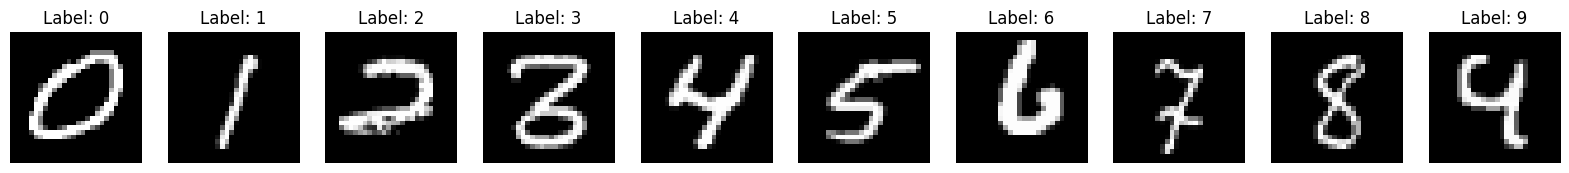

In [8]:
import matplotlib.pyplot as plt

# 0. Prepare the data
transform = transforms.ToTensor()
dataloader = get_data_loader('MNIST', transform, batch_size=128)

# 1. Randomly pick one image from each class (0 - 9) as the test data
test_data = []
for i in range(10):
    for data, labels in dataloader:
        index = (labels == i).nonzero()[0]
        test_data.append((data[index], i))
        break

# 2. Show the selected images
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, (img, label) in enumerate(test_data):
    # print(img.shape)
    axs[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[i].set_title('Label: {}'.format(label))
    axs[i].axis('off')
    print(img.shape)
